In [50]:
import numpy as np
from helpers.plots import plot_toy_signals
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from helpers.plots import plot_two_var_model 
import itertools
from scipy.optimize import curve_fit
from helpers.plots import plot_se 
from helpers.plots import plot_mi 
from scipy.stats import linregress
from helpers.plots import plot_lingress 

# Shannon Entropy

In [51]:
def prob(dataset, max_bins=10):
    """Joint probability distribution P(X) for the given data."""

    # bin by the number of different values per feature
    num_rows, num_columns = dataset.shape
    bins = [min(len(np.unique(dataset[:, ci])), max_bins) for ci in range(num_columns)]

    freq, _ = np.histogramdd(dataset, bins)
    p = freq / np.sum(freq)
    return p

def shannon_entropy(p):
    """Shannon entropy H(X) is the sum of P(X)log(P(X)) for probabilty distribution P(X)."""
    p = p.flatten()
    return -sum(pi*np.log2(pi) for pi in p if pi)

In [52]:
def conditional_shannon_entropy(p, *conditional_indices):
    """Shannon entropy of P(X) conditional on variable j"""

    axis = tuple(i for i in np.arange(len(p.shape)) if i not in conditional_indices)

    return shannon_entropy(p) - shannon_entropy(np.sum(p, axis=axis))

In [53]:
def mutual_information(p, j):
    """Mutual information between all variables and variable j"""
    return shannon_entropy(np.sum(p, axis=j)) - conditional_shannon_entropy(p, j)

In [54]:
def conditional_mutual_information(p, j, *conditional_indices):
    """Mutual information between variables X and variable Y conditional on variable Z."""

    marginal_conditional_indices = [i-1 if i > j else i for i in conditional_indices]

    return (conditional_shannon_entropy(np.sum(p, axis=j), *marginal_conditional_indices)
            - conditional_shannon_entropy(p, j, *conditional_indices))

# MIQUBO

In [55]:
import dimod
bqm = dimod.BinaryQuadraticModel.empty(dimod.BINARY)


In [56]:
gics = pd.read_csv("data/formatted_gics.csv")

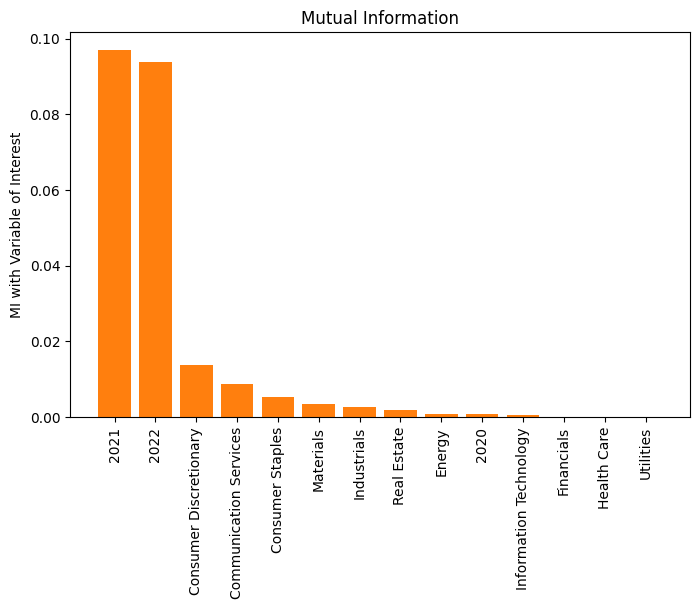

In [57]:
# A plot of the ranking of mutual information between each feature and the variable of interest (sharpe ratio).abs

mi = {}
features = list(set(gics.columns).difference(('Sharpe_Ratio',)))

for feature in features:
    mi[feature] = mutual_information(prob(gics[['Sharpe_Ratio', feature]].values), 1)
plot_mi(mi)

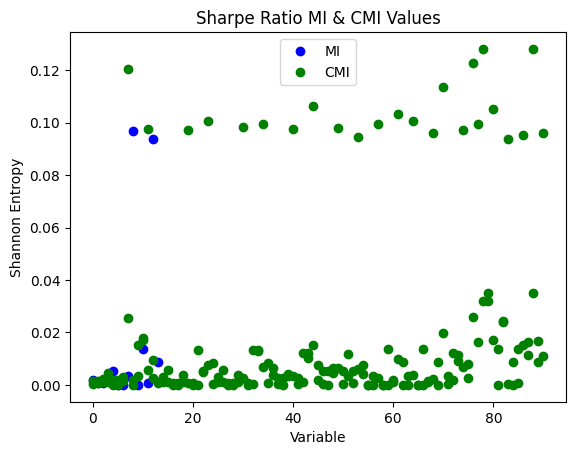

In [58]:
plt.plot(range(len(features)), [mutual_information(prob(gics[['Sharpe_Ratio', feature]].values), 1) for feature in features], 'bo')

plt.plot(range(len([x for x in itertools.combinations(features, 2)])), [conditional_mutual_information(prob(gics[['Sharpe_Ratio', f0, f1]].values), 1, 2) for f0, f1 in itertools.combinations(features, 2)], 'go')
plt.plot(range(len([x for x in itertools.combinations(features, 2)])), [conditional_mutual_information(prob(gics[['Sharpe_Ratio', f1, f0]].values), 1, 2) for f0, f1 in itertools.combinations(features, 2)], 'go')

plt.title("Sharpe Ratio MI & CMI Values")
plt.ylabel("Shannon Entropy")
plt.xlabel("Variable")
plt.legend(["MI", "CMI"])

# Building a mutual information based BQM

In [59]:
# From the MI we keep the 8 top MI freatures
keep = 8

sorted_mi = sorted(mi.items(), key=lambda pair: pair[1], reverse=True)
gics = gics[[column[0] for column in sorted_mi[0:keep]] + ['Sharpe_Ratio']]
features = list(set(gics.columns).difference(('Sharpe_Ratio',)))

print("Submitting for {} features: {}".format(keep, features))

Submitting for 8 features: ['Real Estate', 'Consumer Staples', 'Industrials', 'Materials', '2021', 'Consumer Discretionary', '2022', 'Communication Services']


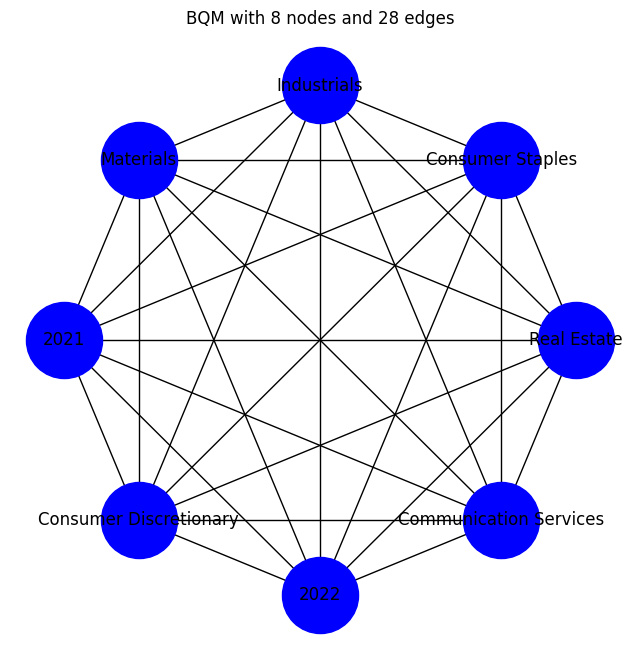

In [60]:
# Calculate a BQM based on the problem's MI and CMI 
from helpers.draw import plot_bqm 

bqm = dimod.BinaryQuadraticModel.empty(dimod.BINARY)

# add the features
for feature in features:
    mi = mutual_information(prob(gics[['Sharpe_Ratio', feature]].values), 1)
    bqm.add_variable(feature, -mi)

for f0, f1 in itertools.combinations(features, 2):
    cmi_01 = conditional_mutual_information(prob(gics[['Sharpe_Ratio', f0, f1]].values), 1, 2)
    cmi_10 = conditional_mutual_information(prob(gics[['Sharpe_Ratio', f1, f0]].values), 1, 2)
    bqm.add_interaction(f0, f1, -cmi_01)
    bqm.add_interaction(f1, f0, -cmi_10)

bqm.normalize()  

plot_bqm(bqm)

# Setting up QPU as a Solver

In [61]:
from dwave.system import DWaveSampler, FixedEmbeddingComposite
from minorminer.busclique import find_clique_embedding

qpu = DWaveSampler()

qpu_working_graph = qpu.to_networkx_graph()
embedding = find_clique_embedding(bqm.variables, qpu_working_graph)

qpu_sampler = FixedEmbeddingComposite(qpu, embedding)

print("Maximum chain length for minor embedding is {}.".format(max(len(x) for x in embedding.values())))

Maximum chain length for minor embedding is 2.


In [62]:
from hybrid.reference.kerberos import KerberosSampler

kerberos_sampler = KerberosSampler() 

Submitting for k=1
Submitting for k=2
Submitting for k=3
Submitting for k=4
Submitting for k=5
Submitting for k=6
Submitting for k=7
Submitting for k=8


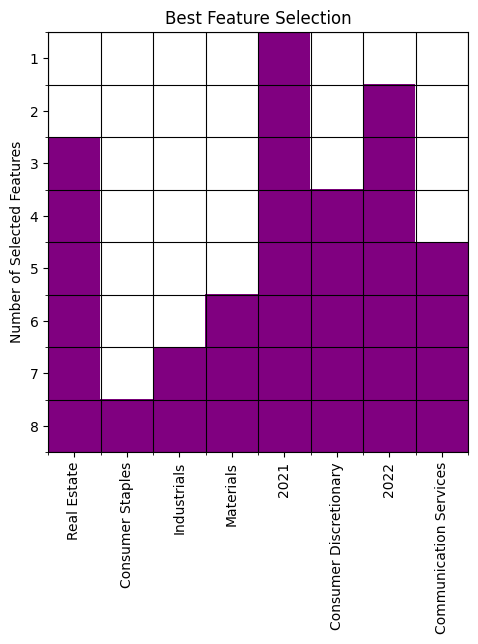

In [63]:
# Submitting the problem for all k values
from helpers.draw import plot_feature_selection 

selected_features = np.zeros((len(features), len(features)))
for k in range(1, len(features) + 1):
    print("Submitting for k={}".format(k))
    kbqm = dimod.generators.combinations(features, k, strength=6)
    kbqm.update(bqm)
    kbqm.normalize()
    
    best = kerberos_sampler.sample(kbqm, 
                                   qpu_sampler=qpu_sampler, 
                                   qpu_reads=5000, 
                                   max_iter=1,
                                   qpu_params={'label': 'Notebook - Feature Selection'}
                                  ).first.sample
    
    for fi, f in enumerate(features):
        selected_features[k-1, fi] = best[f]

plot_feature_selection(features, selected_features)